In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
X, y = make_classification(
    n_samples = 500,
    n_features = 5,
    n_informative = 3,
    n_redundant = 0,
    n_classes = 2,
    random_state = 42)
print(X[:2])
print(y[:2])

[[-1.8306329  -0.09533956 -0.65407568  0.72405061 -0.18131925]
 [ 0.26028051  0.08015108 -0.41346516 -1.27331422  1.48260887]]
[0 1]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Converting to PyTorch tensors -> Pytorch tensors are nothing but arrays that can run in both GPUs and CPUs
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (N,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [32]:
class SimpleNN(nn.Module): #inheriting from nn.Module, which is the base class in PyTorch for all neural networks
    def __init__(self, input_dim, hidden_dim): #constructor
        super(SimpleNN, self).__init__() #calling parent class constructor
        self.fc1 = nn.Linear(input_dim, hidden_dim) #fc = fully connected
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

In [45]:
input_dim = X_train.shape[1]
hidden_dim = 10
model = SimpleNN(input_dim, hidden_dim)

criterion = nn.BCEWithLogitsLoss() #Binary cross entropy with logits loss
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [46]:
epochs = 100
loss_log = []

for epoch in range(epochs):
    model.train()

    #forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.3623
Epoch [20/100], Loss: 0.2817
Epoch [30/100], Loss: 0.2441
Epoch [40/100], Loss: 0.2161
Epoch [50/100], Loss: 0.1941
Epoch [60/100], Loss: 0.1743
Epoch [70/100], Loss: 0.1575
Epoch [80/100], Loss: 0.1444
Epoch [90/100], Loss: 0.1353
Epoch [100/100], Loss: 0.1281


In [47]:
loss_df = pd.DataFrame({'epoch': list(range(1, epochs+1)), 'loss': loss_log})
loss_df.to_csv('training_loss.csv', index=False)


In [48]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.sigmoid(test_outputs).round()  # convert logits to 0/1
    accuracy = (predictions.eq(y_test).sum() / y_test.shape[0]).item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9400


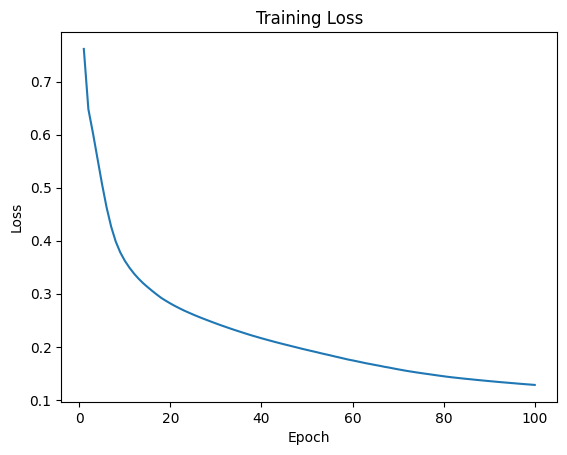

In [49]:
plt.plot(loss_df['epoch'], loss_df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
